In [1]:
import sys
import os
import pandas as pd
import geopandas as gpd
current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path,'..'))  # ,'..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from load_inputs.Lyon.weather import load_data as load_data_subway_in,START, END,FILE_NAME
folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots"

info_stations = {69029001: {'lat': 45.72583,
                           'lon': 4.937777,
                           'name': 'Lyon-Bron'},
                    69299001: {'lat': 45.72639, 
                            'lon': 5.077777,
                            'name': 'Lyon—St Exupery'}}

# lat = "45°43'33“N"
# lon = "4°56'16“E"

# lat	 = "45°43'35“N"
# lat	 = "5°04'40“E"

# convert into gdf:
gdf_info_stations = pd.DataFrame.from_dict(info_stations, orient='index')
gdf_info_stations.index.name = 'station_id'
gdf_info_stations.reset_index(inplace=True)
gdf_info_stations['lat'] = gdf_info_stations['lat'].astype(float)
gdf_info_stations['lon'] = gdf_info_stations['lon'].astype(float)
gdf_info_stations['geometry'] = gdf_info_stations.apply(lambda row: (row['lat'], row['lon']), axis=1)
gdf_info_stations = gpd.GeoDataFrame(gdf_info_stations, geometry=gpd.points_from_xy(gdf_info_stations['lon'], gdf_info_stations['lat']), crs="EPSG:4326")

save_path = f'{folder}/weather_folium.html'# None 
m = gdf_info_stations.explore(tiles= 'Carto DB positron', zoom_start=10,
                               style_kwds= {
                                             'fillColor': 'purple', 
                                             'fillOpacity': 0.7,
                                               'radius': 6,
                                                  'color': 'gray',
                               }
                              )

if save_path is not None:
    m.save(save_path)
m


# Load Data

In [2]:


from load_inputs.Lyon.weather import load_data as load_data_subway_in,START, END,FILE_NAME
from pipeline.plotting.TS_analysis import plot_TS
from argparse import Namespace
from examples.benchmark import local_get_args
from constants.paths import FOLDER_PATH

invalid_dates = []
minmaxnorm = True
standardize = False  # Set to True if you want to standardize the data
config = {'model_name': 'STGCN',
         'freq' : '15min',
        'dataset_names':['weather'],
        'dataset_for_coverage' : ['subway_in'],
        'target_data': 'weather',
        'contextual_kwargs':{'weather':{},
                           },
        'target_kwargs':{'weather':{'quantile_filter_outliers':0.995,}},
        'step_ahead':1,
        'horizon_step':1,
        }

args = local_get_args(config['model_name'],
                args_init = None,
                dataset_names=config['dataset_names'],
                dataset_for_coverage=config['dataset_for_coverage'],
                modification = config)



coverage_period = pd.date_range(start=START, end=END, freq='15min')[:-1]  # Exclude the last date to match the data
args_out = Namespace(**vars(args))  
args_out.target_data = 'weather'
args_out.dataset_for_coverage = ['weather']
args_out.dataset_names = ['weather']
args_out.contextual_kwargs = {}


ds = load_data_subway_in(FOLDER_PATH, coverage_period=coverage_period, invalid_dates=invalid_dates, args=args_out, minmaxnorm=minmaxnorm,standardize=standardize, normalize=True,filename=FILE_NAME,
              tensor_limits_keeper = None)

df_raw = pd.DataFrame(ds.raw_values,columns = ds.spatial_unit, index = ds.df_dates['date'])
# df =  pd.DataFrame(ds.U_train[:,:,-1].detach().cpu().numpy(),columns = ds.spatial_unit, index = ds.tensor_limits_keeper.df_verif_train.iloc[:,-2] )
df = df_raw[(df_raw.index <=pd.to_datetime("2020-01-01")) &
        (df_raw.index >=pd.to_datetime("2019-01-01"))
        ]
df.columns.name = 'Spatial Unit ID'
df.index.name = 'date'

from pipeline.plotting.TS_analysis import plot_TS

plot_TS(list_df_ts=df,width = 1200,height=400,bool_show= True,
        title = 'Rainfall Intensity (mm/h) - Lyon - NetMob Dataset',
        )

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Values with issues:  0.001%
Regular Values that we have to set to 0:  0.000%
Values with issues:  0.014%
Regular Values that we have to set to 0:  0.000%


Loading BokehJS ...

figure(id='p1001', ...)

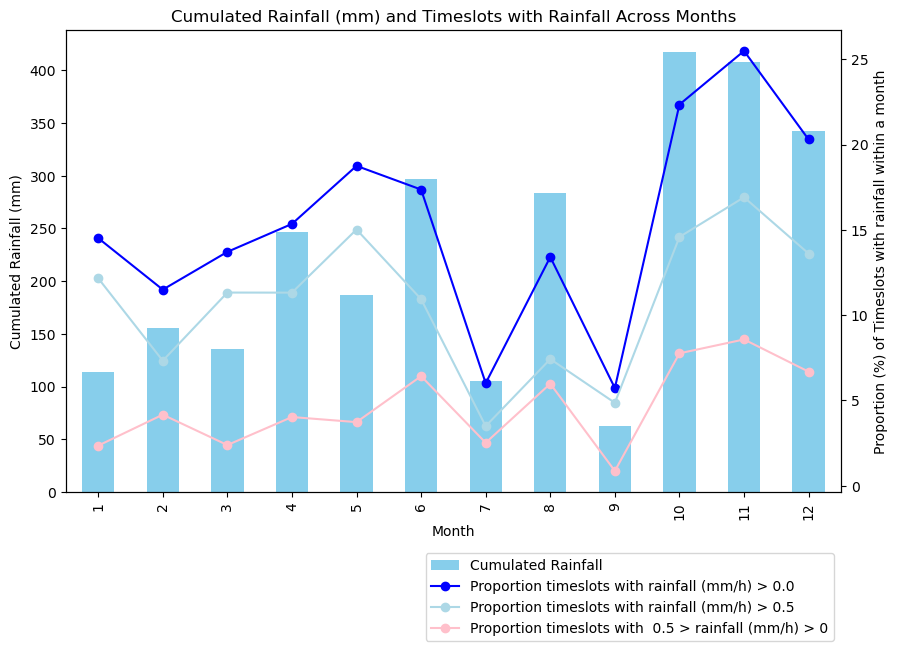

In [3]:
df_mean = df.mean(axis=1)
df_positiv = df_mean[df_mean>0]
df_positiv = df_positiv.reset_index()
df_positiv['hour'] = df_positiv['date'].dt.hour
df_positiv['month'] = df_positiv['date'].dt.month

import matplotlib.pyplot as plt
import numpy as np
# Histogram 1: Cumulative rainfall (mm/h) across months
fig, ax1 = plt.subplots(figsize=(10, 6))
cumulative_rainfall = df_positiv.groupby('month')[0].sum()
cumulative_rainfall.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Cumulated Rainfall (mm)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Cumulated Rainfall (mm) and Timeslots with Rainfall Across Months')
ax2 = ax1.twinx()

df_positiv_copy = df_positiv.copy()
df_positiv_copy['month'] = df_positiv_copy['month'].apply(lambda x : x-1)
day_per_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
proportion_timeslots_per_month = (day_per_month*4*24)/100 
num_rainy_events = df_positiv_copy.groupby('month').size()/proportion_timeslots_per_month
num_rainy_events_ge_05 = df_positiv_copy[df_positiv_copy[0] >= 0.5].groupby('month').size()/proportion_timeslots_per_month
num_rainy_events_lt_05 = df_positiv_copy[df_positiv_copy[0] < 0.5].groupby('month').size()/proportion_timeslots_per_month

num_rainy_events.plot(kind='line', color='blue', marker='o', ax=ax2)
num_rainy_events_lt_05.plot(kind='line', color='lightblue', marker='o', ax=ax2)
num_rainy_events_ge_05.plot(kind='line', color='pink', marker='o', ax=ax2)


ax2.set_ylabel('Proportion (%) of Timeslots with rainfall within a month', color='black')
ax2.tick_params(axis='y', labelcolor='black')
fig.legend(['Cumulated Rainfall',
            'Proportion timeslots with rainfall (mm/h) > 0.0', 'Proportion timeslots with rainfall (mm/h) > 0.5 ', 'Proportion timeslots with  0.5 > rainfall (mm/h) > 0'], loc='lower right', bbox_to_anchor=(0.9, -0.15))

save_path = f'{folder}/weather_hist/weather_rainfall_hist_across_months.pdf'
fig.savefig(save_path, bbox_inches='tight')

plt.show()



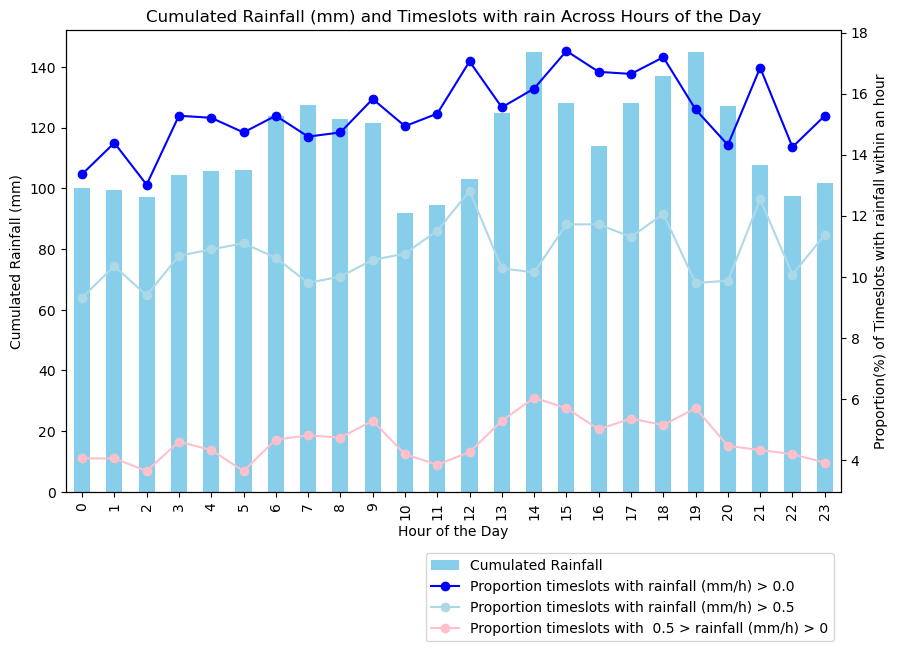

In [4]:
# Histogram 2: Cumulative rainfall (mm/h) across hours of the day
fig, ax1 = plt.subplots(figsize=(10, 6))
cumulative_rainfall_hour = df_positiv.groupby('hour')[0].sum()
cumulative_rainfall_hour.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Cumulated Rainfall (mm)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Cumulated Rainfall (mm) and Timeslots with rain Across Hours of the Day')
ax2 = ax1.twinx()


number_of_timeslots_per_year = 24*365*4
proportion_hour_through_dataset = number_of_timeslots_per_year/24/100
num_rainy_events = df_positiv.groupby('hour').size()/proportion_hour_through_dataset
num_rainy_events_ge_05 = df_positiv[df_positiv[0] >= 0.5].groupby('hour').size()/proportion_hour_through_dataset
num_rainy_events_lt_05 = df_positiv[df_positiv[0] < 0.5].groupby('hour').size()/proportion_hour_through_dataset

num_rainy_events.plot(kind='line', color='blue', marker='o', ax=ax2)
num_rainy_events_lt_05.plot(kind='line', color='lightblue', marker='o', ax=ax2)
num_rainy_events_ge_05.plot(kind='line', color='pink', marker='o', ax=ax2)


ax2.set_ylabel('Proportion(%) of Timeslots with rainfall within an hour', color='black')
ax2.tick_params(axis='y', labelcolor='black')
fig.legend(['Cumulated Rainfall',
            'Proportion timeslots with rainfall (mm/h) > 0.0', 'Proportion timeslots with rainfall (mm/h) > 0.5 ', 'Proportion timeslots with  0.5 > rainfall (mm/h) > 0'], loc='lower right', bbox_to_anchor=(0.9, -0.15))

save_path = f'{folder}/weather_hist/weather_rainfall_hist_across_hours.pdf'
fig.savefig(save_path, bbox_inches='tight')

plt.show()


Number of remaining time-slots after filtering 3355
Number of remaining time-slots after filtering 2040


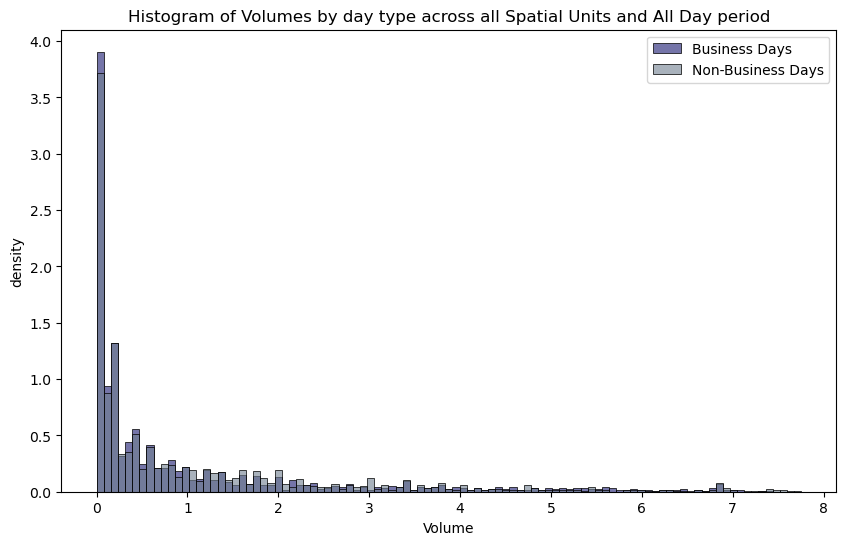

Number of remaining time-slots after filtering 3355
Number of remaining time-slots after filtering 2040


/home/rrochas/prediction-validation/load_inputs/systematic_analysis/utils.py:383: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q = df_combined.groupby(['Spatial Unit ID', 'day_type'])['Volume'].agg(
/home/rrochas/prediction-validation/load_inputs/systematic_analysis/utils.py:393: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_max = df_combined.groupby(['Spatial Unit ID', 'day_type'])['Volume'].max().reset_index()


<Figure size 1200x600 with 0 Axes>

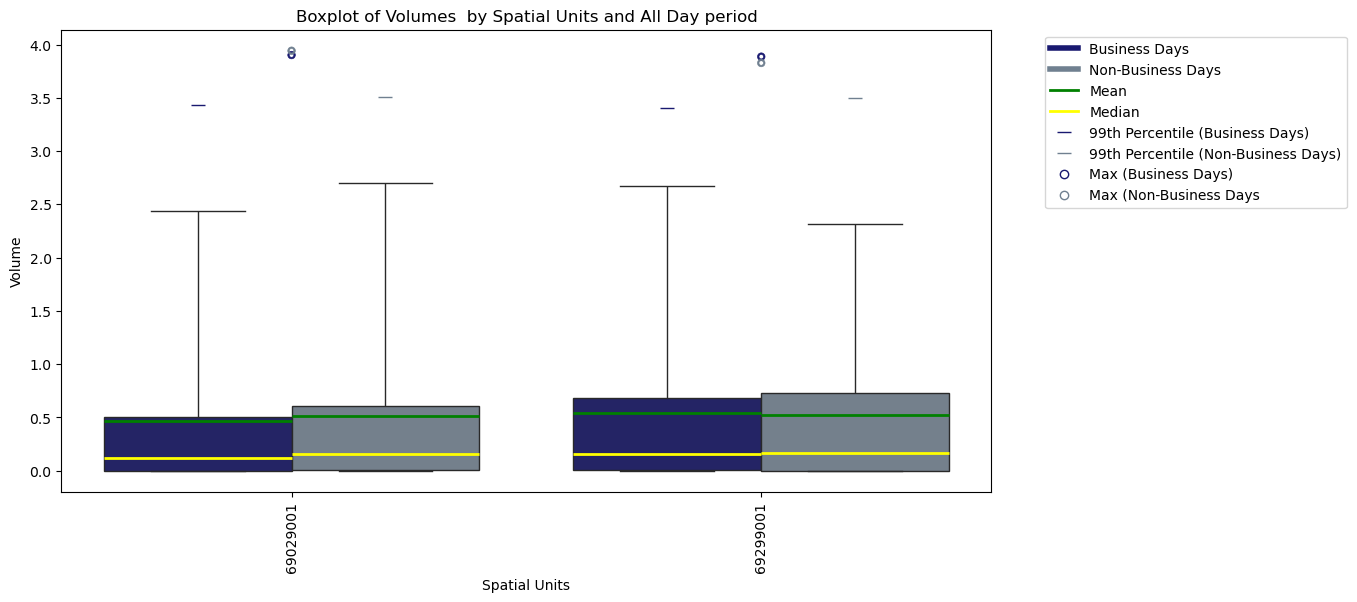

In [5]:
from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc
city = 'Lyon'
palette = [IN_bdc, IN_nbdc]
stats = 'density'

df_positiv = df[df.sum(axis=1)>0]

save_path = f'{folder}/weather_hist/weather_hist_{stats}.pdf'# None 
ts_bd, ts_nbd = get_histogram_per_day_type(df_positiv,city= city,period = 'all_day',stats = stats, palette = palette,n_bins = 100, save_path= save_path)

save_path = f'{folder}/weather_boxplot/weather_boxplot.pdf'# None
df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_positiv,period = 'all_day',city= city, palette = palette, save_path= save_path)

/tmp/ipykernel_62405/108794012.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ts = ts .applymap(lambda x: 0 if x < 0.05 else x)


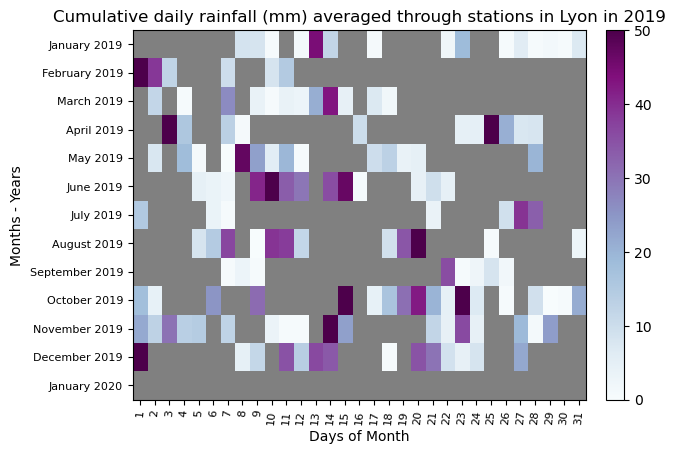

In [15]:
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
ts = pd.DataFrame(df.mean(axis= 1))

save_path = f'{folder}/weather_heatmap/weather_heatmap.pdf'# None
# Filter out low rainfall values
ts = ts .applymap(lambda x: 0 if x < 0.05 else x)
df_agg = heatmap(ts,
                 city= city,
                 cmap = cmap,
                 filter_q = 0.99,
                 bool_reversed = bool_reversed,
                 vmin = 0,
                 vmax = 50,
                 title = 'Cumulative daily rainfall (mm) averaged through stations in Lyon in 2019',
                 save_path = save_path 
                 )